In [1]:
import numpy as np
import math
import torch
import random
import torch.nn as nn
from torch.utils.data import TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary

### Sequencias de Fibonacci y "de" Neil Sloane
<img src="sequences.png" alt="Alternative text" width="800"/>

In [2]:
a_cache, b_cache = {}, {}

def a(n):
    if n in a_cache:
        return a_cache[n]    
    ###      Fibonacci 
    if n == 0 or n == 1:
        
        return 1
    else:
        a_cache[n] = a(n-1) + a(n-2)
        return a(n-1) + a(n-2)

def b(n):
    if n in b_cache:
        return b_cache[n] 
    ###     Neil
    if n == 0 or n == 1:
        return 1
    else: 
        gcd = math.gcd(b(n-1),n)
        if gcd == 1:
            b_cache[n] = b(n-1) + n + 1
            return b(n-1) + n + 1
        else:
            b_cache[n] = int(b(n-1)/gcd)
            return int(b(n-1)/gcd)

n         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Fibonacci [1, 1, 2, 3, 5, 8, 13, 21]
Neil      [1, 1, 4, 8, 2, 8, 4, 12]


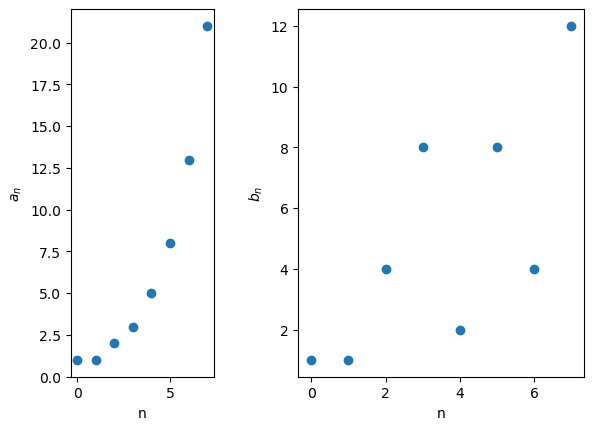

In [20]:
N=8;  seq1, seq2 = [a(n) for n in range(N)], [b(n) for n in range(N)]
print('n        ',[i for i in range(10)])
print('Fibonacci',seq1[:10])
print('Neil     ',seq2[:10])
fig, axes = plt.subplots(nrows=1,ncols=2,width_ratios=[1, 2])
fig.tight_layout(pad=3.0)
axes[0].scatter(range(N),seq1); axes[0].set(xlabel='n', ylabel='$a_n$')
axes[1].scatter(range(N),seq2); axes[1].set(xlabel='n', ylabel='$b_n$')

seq1 = torch.tensor(seq1,dtype=torch.float32)
seq2 = torch.tensor(seq2,dtype=torch.float32)

### <font color='red'> Tarea 1: armando el dataset con la serie de tiempo
Implementar en la rutina *input_data* diferentes formas de armar nuestras observaciones.
    
(a) Sampleo aleatorio: recortar trozos de largo ws pero alrededor de un índice elejido al aza


In [4]:
def input_data(seq,ws,opt=1):     # input: chunk[:-1], label: ichunk[-1] 
    chunks = [];
    
    if opt == 1:
        for i in range(len(seq) - ws):
            chunks.append( (seq[i:i+ws], seq[i+ws:i+ws+1])  )
    if opt == 2:
        pass # HACER
            
    return chunks

In [21]:
window_size = 4
data = input_data(seq2, window_size)
print('Lenghts: seq, chunks ->',len(seq2),len(data))
data[:4]

Lenghts: seq, chunks -> 8 4


[(tensor([1., 1., 4., 8.]), tensor([2.])),
 (tensor([1., 4., 8., 2.]), tensor([8.])),
 (tensor([4., 8., 2., 8.]), tensor([4.])),
 (tensor([8., 2., 8., 4.]), tensor([12.]))]

In [22]:
test_size=int(0.33*len(data))
train = data[:-test_size]
test = data[-test_size:]
print('Lenghts: train, test ->',len(train),len(test))

Lenghts: train, test -> 3 1


In [23]:
test[0]

(tensor([8., 2., 8., 4.]), tensor([12.]))

## RNN
<img src="Recurrent_neural_network_unfold.png" alt="Alternative text" width="800"/>
<img src="cap1.png" alt="Alternative text" width="800"/>

In [24]:
# Ejemplo para entender la documentación
batch_size = 3
rnn = nn.RNN(1, 20, 2)
inputs = torch.randn(4, batch_size, 1)  # inputs: secuencia de longitud 5, un tamaño de lote de 3 y cada elemento de la secuencia tiene 10 características.
h0 = torch.randn(2, batch_size, 20)      # 2 capas apiladas, un tamaño de lote de 3 y cada capa tiene un estado oculto de 20 características.
out, hn = rnn(inputs, h0)
print('RNN output  ',out.shape)
fcnn = nn.Linear(20, 1)
output = fcnn(out)
print('FCNN output ',output.shape)

RNN output   torch.Size([4, 3, 20])
FCNN output  torch.Size([4, 3, 1])


In [9]:
seq, y_train = train[0]
seq.view(len(seq),1,-1)

tensor([[[1.]],

        [[1.]],

        [[4.]],

        [[8.]]])

<img src="Heman.jpeg" alt="Alternative text" width="300"/>

In [16]:
class RNN(nn.Module):
    
    def __init__(self, input_size = 1, hidden_size = 50, output_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        rnn_out, self.hidden = self.rnn(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(rnn_out.view(len(seq),-1))
        return pred[-1]

In [17]:
torch.manual_seed(42)
model = RNN()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
print(model,'\n');print(optimizer)

RNN(
  (rnn): RNN(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
) 

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [19]:
epochs = 10

for i in range(epochs):
    for seq, y_train in train:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")

AttributeError: 'tuple' object has no attribute 'dim'

In [ ]:
# Datos de ejemplo: una secuencia de números
sequence = chunks

# Hiperparámetros
input_size = 1  # Dimensión de entrada (un número a la vez)
hidden_size = 26  # Tamaño del estado oculto
output_size = 1  # Dimensión de salida
learning_rate = 0.01
num_epochs = 1000


# Crear el modelo y la función de pérdida
model = RNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Preparar los datos
data = torch.tensor(sequence[:-1]).view(1, len(sequence) - 1, input_size).float()
target = torch.tensor(sequence[1:]).view(1, len(sequence) - 1, output_size).float()

# Entrenamiento del modelo
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

In [ ]:
# Predicción
model.eval()
with torch.no_grad():
    initial_input = torch.tensor(sequence[:-1]).view(1, len(sequence) - 1, input_size).float()
    predicted_value = model(initial_input).view(-1).item()
    print("Siguiente valor predicho:", predicted_value)

## LSTM

In [ ]:
class LSTM(nn.Module):
    
    def __init__(self,input_size = 1, hidden_size = 50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [ ]:
torch.manual_seed(42)
model     = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
model

In [ ]:
epochs = 10
future = 10

for i in range(epochs):
    
    for chunk, y_train in train:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(chunk)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    preds = seq2[-window_size:].tolist()
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                           torch.zeros(1,1,model.hidden_size))
            preds.append(model(chunk).item())
        
    loss = criterion(torch.tensor(preds[-window_size:]), seq2[len(seq2)-window_size:])
    print(f"Performance on test range: {loss}")

In [ ]:
summary(model,input_size=(len(sequence)-1,2) )